# All the President's Moods

For at least 4 years, a certain public figure was very active on Twitter...

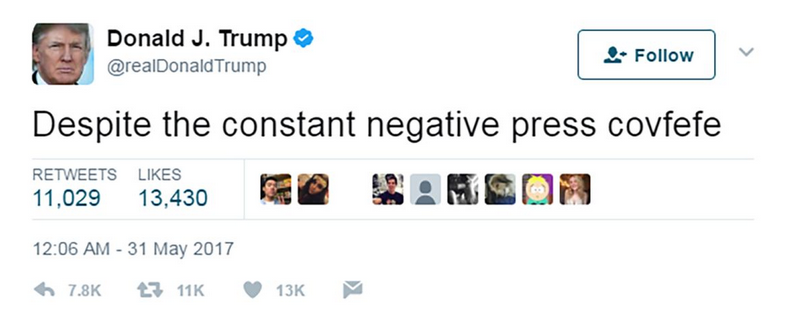

## Trump and Twitter

During his tenure as US President, Donald Trump maintained a steady presence on Twitter. Since the words of the politicians tend to affect the behavior of other people, including markets, there is a sizable literature quantifying the effect of politician speeches on market behavior in the aggregate. 


## Case Study: The 2020 Election

Unllke other politicians, Trump's tweets were both impassioned and plentiful. This means Twitter can give a large volume of reactions to work with that have a distribution of "sentiment."

In this example, we will look at Trump's tweets around the 2020 election. 

In [30]:
import pandas as pd
import json 
import matplotlib.pyplot as plt
import matplotlib
import re
import string
from nltk.corpus import stopwords
import regex
import nltk
from datetime import timedelta
from nltk.sentiment.vader import SentimentIntensityAnalyzer

## 1. Read Tweets

Reading Trump Tweets

In json format:

In [31]:
dir_ = "C:/Users/jhtchns2/Box/ACE 592 SAE/Class_Examples/1_Text/"
with open(dir_+"Trump_tweets.json") as f:
    tweets = json.load(f)

Let's extract some features and put them in a dataframe:

In [32]:
df = pd.DataFrame()

# Full text
df['full_text'] = [x['full_text'] for x in tweets]

# User mentions (list)
df['user_mentions'] = [[ x['screen_name'] for x in y['entities']['user_mentions'] ] for y in tweets]

# Number of times its been retweeted
df['RTs'] = [x['retweet_count'] for x in tweets]

# Number of likes
df['favs'] = [x['favorite_count'] for x in tweets]

# Censored tweets have zero RTs
df['censored'] = df['RTs']==0

### Note: extended text and retweets

In the case that there is an "extended_tweet" key, the "full_text" key does not exit.

If that is the case, you have to extract it doing something like this: 

An inelegant solution:

In [33]:
ext_text = []

for tweet in tweets:
    if "retweeted_status" in list(tweet.keys()): # Is one of the keys "retweeted_status"
        if "extended_tweet" in list(tweet['retweeted_status'].keys()): # Is one of they keys in "extended tweet"
            ext_text += [tweet['retweeted_status']['extended_tweet']['full_text']]
        else:
            ext_text += [tweet['retweeted_status']['full_text']] # If not, take "text"
    elif "extended_tweet" in list(tweet.keys()): # Is one of the keys "extended_tweet"
        ext_text += [tweet['extended_tweet']['full_text']]
    else:
        ext_text += [tweet['full_text']] # If not, take "text"

df['text'] = ext_text

Time features

In [34]:
df['time_stamp'] = [x['created_at'] for x in tweets]

# Convert to CT time (its at Greenwich by default)
df['time_stamp'] = pd.to_datetime(df['time_stamp']) - timedelta(hours=6)

# Date, which is just chopping off the time part
df['date'] = df.time_stamp.apply(lambda x:  str(x)[:10])
df['date'] = pd.to_datetime(df.date)

C:\Users\jhtchns2\AppData\Local\Temp\ipykernel_20804\2796276945.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['time_stamp'] = pd.to_datetime(df['time_stamp']) - timedelta(hours=6)


To drop duplicates, I'll take the one with the most favorites.

In [35]:
df = df.sort_values(by=['time_stamp','full_text',"favs"])

df = df.groupby(['time_stamp','full_text']).last().reset_index()

## Word Counts

### Top 10 Words
#### Remove Links and User Tags

I'm going to use regular expressions here

In [36]:
import re

# Regex functions to find each one
find_links = re.compile(r'http\S+')
find_users = re.compile(r'@\w+')
find_hashtags = re.compile(r'#\w+')

# "sub" them for an empty string
df['text_nolink'] = [find_links.sub("",x) for x in df['full_text']]
df['text_nolink'] = [find_users.sub("",x) for x in df['text_nolink']]
df['text_nolink'] = [find_hashtags.sub("",x) for x in df['text_nolink']]

#### Remove punctuation and lowercase

In [37]:
import string
string.punctuation

# This maketrans function can be used to remove a list of characters from a string.
remv_punc = str.maketrans('','',string.punctuation + '“' +"‘"+'”')

df['text_lower'] =  df['text_nolink'].str.lower().str.replace("\n"," ")

df['text_clean'] = df.text_lower.str.translate(remv_punc)

#### Split into words

In [38]:
from nltk.corpus import stopwords

sw_list = stopwords.words('english') + ['amp',''," "]

df['words'] = [x.split(" ") for x in df['text_clean']]

#### Take out Stop Words

In [39]:
df['words'] = [list(set(x) - set(sw_list)) for x in df['words']]

#### Get the words counts

Slow way:

In [40]:
series_list = [pd.Series(x).value_counts() for x in df['words']]
word_df = pd.concat(series_list,axis=1).fillna(0).T.reset_index(drop=True)

In [41]:
word_df.sum().sort_values(ascending=False).head(20)

great        249.0
biden        240.0
vote         188.0
thank        185.0
joe          180.0
people       122.0
big           98.0
trump         96.0
america       92.0
get           89.0
fake          85.0
total         84.0
amendment     81.0
news          80.0
country       79.0
president     76.0
second        76.0
never         74.0
jobs          74.0
election      74.0
dtype: float64

If the data is big, that method is very memory and time-consuming.

I am going to use an sklean vectorizer here. Part of the reason sklearn is more efficient in this case is that it uses __sparse matrices__ to do the computations.

In [42]:
from sklearn.feature_extraction.text import CountVectorizer

vct = CountVectorizer(stop_words=sw_list)

X = vct.fit_transform(list(df['text_clean']))

In [43]:
X

<1789x4003 sparse matrix of type '<class 'numpy.int64'>'
	with 18343 stored elements in Compressed Sparse Row format>

This matrix currently holds 17k entries, but somehow does it efficiently. How?

### Sparse Matrices
- Matrices where most of the elements are zero.
- If you are using int64, its taking up 64 bits just to put zeros. What a waste!
- One format is called __Compressed Sparse Row__ and holds this data more efficiently. From the Wikipedia page:
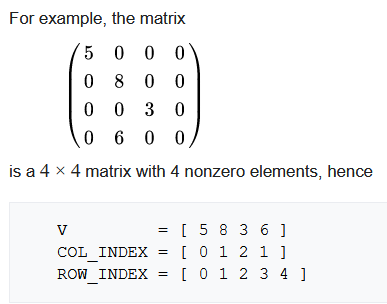    Holding three one-dimensional arrays is much more efficient than a giant two-dimensional array.

A handy feature here is that you can still do normal operations on a sparse matrix. I will sum it and then make it a dataframe:

In [44]:
word_counts = pd.DataFrame(X.sum(axis=0))

I can label columns by extracting the "feature names"

In [45]:
word_counts.columns = vct.get_feature_names_out()
word_counts = word_counts.T

Top 10 words

In [46]:
word_counts[0].sort_values(ascending=False).head(20)

biden           319
great           264
vote            233
joe             215
thank           186
people          133
get             123
america         111
big             108
trump           106
president        90
country          90
fake             89
pennsylvania     87
total            85
would            84
amendment        84
news             81
jobs             81
election         81
Name: 0, dtype: int64

### Which of the words are hashtags and mentions?
How shall we find hashtags and mentions?

How you extract them is an exercise for you 

__(but here's a hint: CountVectorizer accepts regular expressions...)__

#### Bar Chart

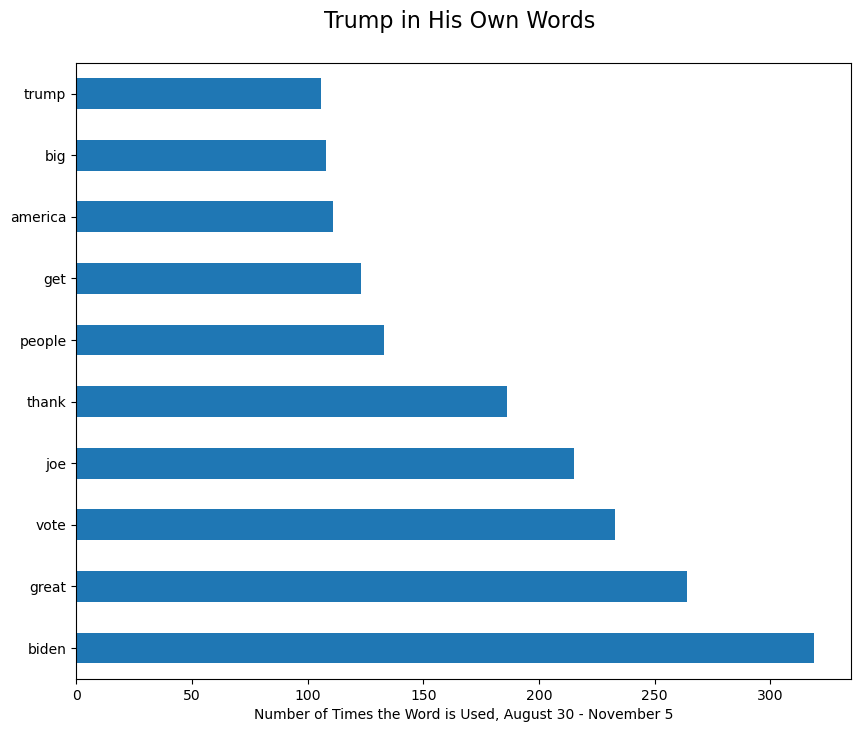

In [47]:
word_counts[0].sort_values(ascending=False).head(10).plot(kind='barh',figsize=(10,8))
plt.xlabel("Number of Times the Word is Used, August 30 - November 5")
plt.title("Trump in His Own Words \n",fontsize=16)
plt.savefig("trump_words.png",dpi=250,bbox_inches="tight")

### Most Favorited

In [48]:
favor_5 = df.sort_values("favs",ascending=False).head()[['time_stamp','full_text','favs']]

favor_5.columns = ['Time Stamp',"Tweet",'Number of Favorites']

In [49]:
pd.set_option('display.max_colwidth', None)
favor_5[['Tweet','Time Stamp',"Number of Favorites"]]

,Tweet,Time Stamp,Number of Favorites
773,"Tonight, @FLOTUS and I tested positive for COVID-19. We will begin our quarantine and recovery process immediately. We will get through this TOGETHER!",2020-10-01 22:54:06+00:00,1858018
775,"Going welI, I think! Thank you to all. LOVE!!!",2020-10-02 21:31:34+00:00,1202110
1770,WE ARE LOOKING REALLY GOOD ALL OVER THE COUNTRY. THANK YOU!,2020-11-03 17:15:55+00:00,957283
1771,I will be making a statement tonight. A big WIN!,2020-11-03 23:45:53+00:00,925883
1763,This Tweet from @realDonaldTrump has been withheld in response to a report from the copyright holder. Learn more.,2020-11-03 01:57:08+00:00,905506


## Tweet Volume

In [50]:
top20_dates = df.date.value_counts().head(20)

top20_dates

date
2020-11-02    69
2020-10-30    63
2020-10-12    63
2020-10-31    62
2020-10-27    61
2020-11-01    51
2020-09-08    48
2020-10-07    48
2020-10-13    46
2020-09-30    40
2020-10-24    39
2020-10-21    39
2020-09-17    39
2020-09-10    38
2020-09-29    37
2020-09-14    37
2020-10-17    36
2020-10-06    36
2020-09-09    35
2020-09-12    31
Name: count, dtype: int64

#### Some important dates:
- Sept 29th: First Presidential Debate
- Oct 15th: Planned Second Debate (which Trump refused to show up for).
- Oct 22nd: Final Debate
- Nov 3rd: Election Day

In [51]:
dates = df.date.sort_values().drop_duplicates().reset_index(drop=True)

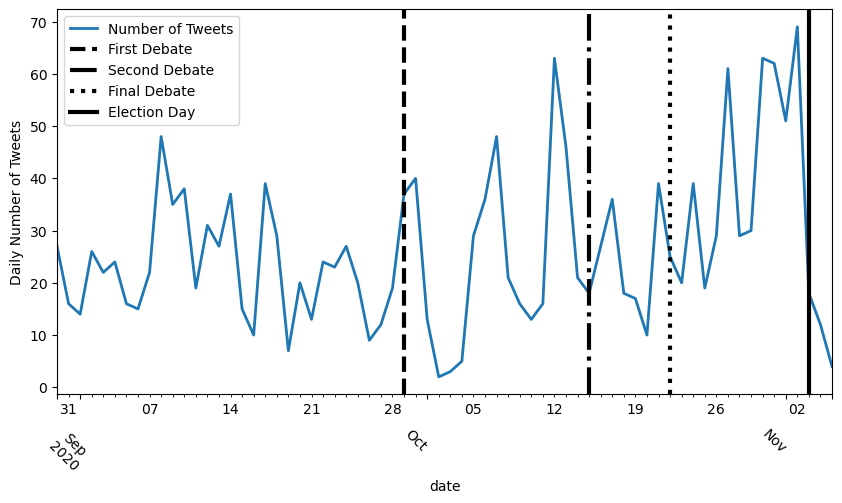

In [52]:
df.date.value_counts().sort_index().plot(label="Number of Tweets",figsize=(10,5),lw=2)
plt.xticks(rotation=-45)

plt.axvline("2020-09-29",ls="--",color="black",label="First Debate",lw=3)
plt.axvline("2020-10-15",ls="-.",color="black",label="Second Debate",lw=3)
plt.axvline("2020-10-22",ls=":",color="black",label="Final Debate",lw=3)
plt.axvline("2020-11-03",ls="-",color="black",label="Election Day",lw=3)

plt.ylabel("Daily Number of Tweets")
plt.legend(loc="upper left")

#### Top 5 words on those days

In [53]:
important_dates = ["2020-09-29","2020-10-15","2020-10-22","2020-11-03"]

In [55]:
word_df = pd.concat([df[['date']],word_df],axis=1)

def top5_words(date):
    this_day = word_df[word_df.date==date]
    word_sums = this_day.iloc[:,1:].sum()
    top5_words = word_sums.sort_values(ascending=False).head().index
    return list(top5_words)

words_on_days = pd.DataFrame([top5_words(x) for x in top20_dates.index])

words_on_days.columns = [1,2,3,4,5]

words_on_days.index = top20_dates.index

In [56]:
words_on_days

,1,2,3,4,5
date,,,,,
2020-11-02,biden,vote,joe,american,get
2020-10-30,biden,vote,joe,america,president
2020-10-12,joe,vote,biden,big,sleepy
2020-10-31,total,complete,endorsement,second,amendment
2020-10-27,thank,great,vote,wisconsin,biden
2020-11-01,biden,joe,great,thank,vote
2020-09-08,great,biden,thank,democrats,new
2020-10-07,vote,biden,president,great,years
2020-10-13,pennsylvania,people,vote,thank,airport


## Sentiment Analysis

In [57]:
sid = SentimentIntensityAnalyzer()

pol_scores = [sid.polarity_scores(x)['compound'] for x in df['text_clean']]

df['sentiment'] = pd.Series(pol_scores)

In [58]:
sent_ts = df.set_index("time_stamp").sort_index()

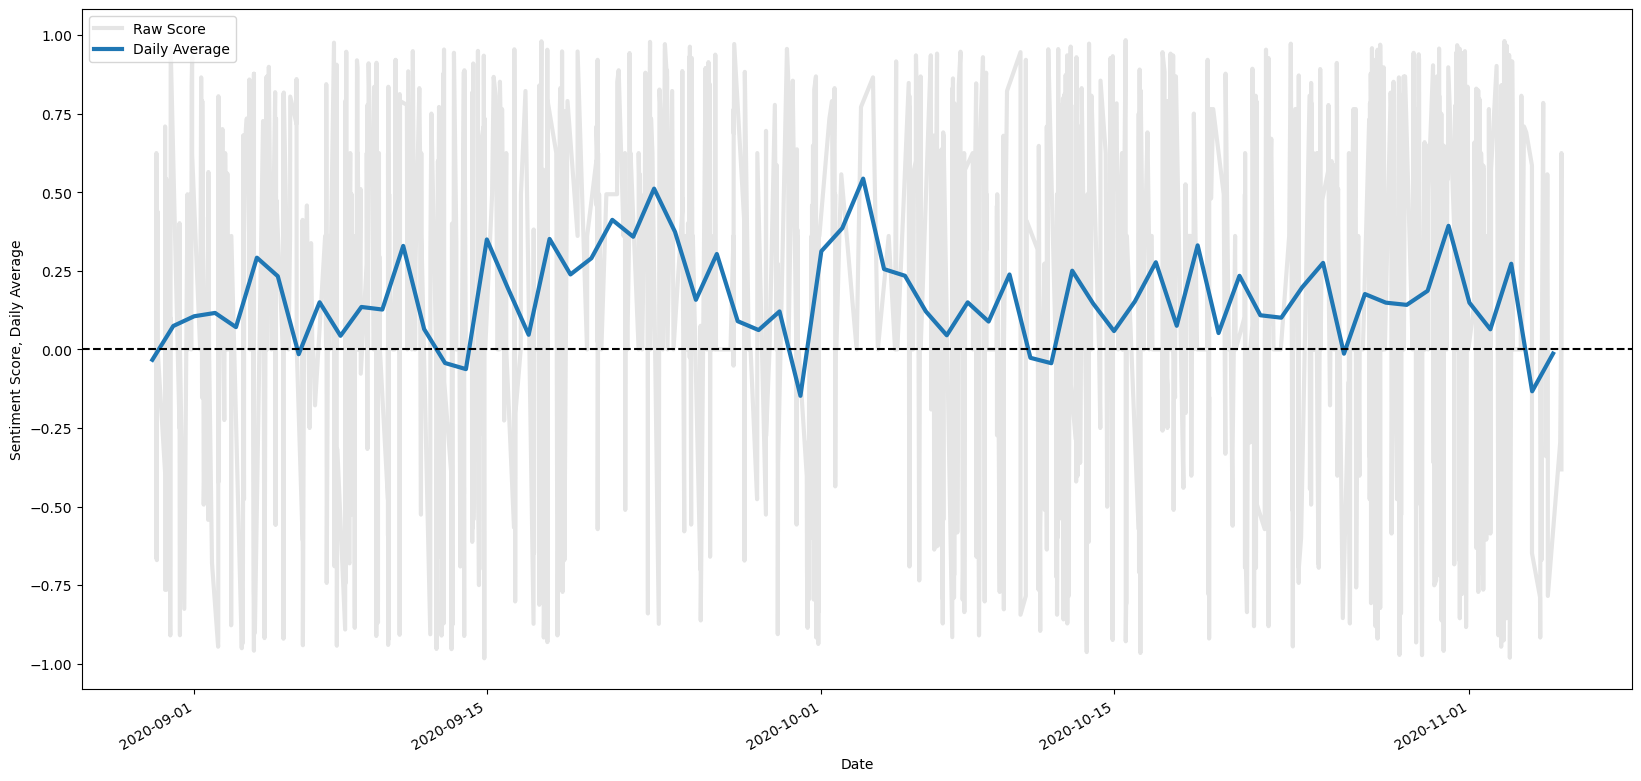

In [59]:
f,a = plt.subplots(figsize=(20,10))
sent_ts['sentiment'].plot(alpha=.1,ax=a,color="black",label="Raw Score",lw=3)
df.groupby("date")['sentiment'].mean().plot(ax=a,label="Daily Average",lw=3)

# df.groupby("date")['sentiment'].mean().plot()
plt.axhline(0,color="black",ls="--")
# plt.xticks(rotation=-45)
plt.ylabel("Sentiment Score, Daily Average")
plt.xlabel("Date")

plt.legend()

#### What do the happiest and saddest tweets look like?

In [60]:
df.set_index("time_stamp").sort_values("sentiment")[['full_text','sentiment']].head()

,full_text,sentiment
time_stamp,,
2020-09-14 21:04:33+00:00,"According to press reports, Iran may be planning an assassination, or other attack, against the United States in retaliation for the killing of terrorist leader Soleimani, which was carried out for his planning a future attack, murdering U.S. Troops, and the death &amp; suffering...",-0.9829
2020-11-02 22:25:17+00:00,"Our prayers are with the people of Vienna after yet another vile act of terrorism in Europe. These evil attacks against innocent people must stop. The U.S. stands with Austria, France, and all of Europe in the fight against terrorists, including radical Islamic terrorists.",-0.9810
2020-10-29 17:34:47+00:00,"Failed RINO former Governor Rick Snyder of Michigan was a disaster with respect to the Flint Water CATASTROPHE, and a very bad Governor overall. He hurt so many people with his gross incompetence. He reminds me of Sleepy Joe!",-0.9729
2020-10-28 15:42:48+00:00,"Who is Miles Taylor? Said he was “anonymous”, but I don’t know him - never even heard of him. Just another @nytimes SCAM - he worked in conjunction with them. Also worked for Big Tech’s @Google. Now works for Fake News @CNN. They should fire, shame, and punish everybody....",-0.9721
2020-10-16 06:15:38+00:00,"Steve Scully of @cspan had a very bad week. When his name was announced, I said he would not be appropriate because of conflicts. I was right! Then he said he was hacked, he wasn’t. I was right again! But his biggest mistake was “confiding” in a lowlife loser like the Mooch. Sad!",-0.9659


The top two saddest tweets are about terrorism and assasination, the rest have an agressive tone speaking about various people.

In [61]:
df.set_index("time_stamp").sort_values("sentiment",ascending=False)[['full_text','sentiment']].head()

,full_text,sentiment
time_stamp,,
2020-10-15 13:20:21+00:00,"It was great to be back in North Carolina with thousands of loyal, hardworking American Patriots! This election is a simple choice: If Biden Wins, China Wins. When WE Win, YOU WIN, North Carolina WINS, and America WINS! https://t.co/jWYVYZdT3E",0.9843
2020-11-02 16:12:45+00:00,"As Christians throughout this great Country celebrate All Souls Day, let’s remember those who went before us and built this great nation. May their legacy inspire us as we keep our nation what it has always been: blessed and great!",0.9816
2020-09-17 14:38:16+00:00,"I would like to extend best wishes and a very happy 70th birthday to the Prime Minister of India, @narendramodi. Many happy returns to a GREAT LEADER and loyal friend! https://t.co/CWlVkHk16X",0.9806
2020-09-22 19:20:26+00:00,"I was honored to be back in the Commonwealth of Pennsylvania with thousands of loyal, hardworking American Patriots. This election is a choice between Pennsylvania &amp; China. If Biden wins, China wins. When we win, Pennsylvania Wins, and AMERICA WINS! #MAGA https://t.co/GTSNoUDpHf",0.9788
2020-09-07 16:30:32+00:00,"Congratulations to Dustin Johnson @DJohnsonPGA on not only a great winning streak and golf season, but on capping it off with a fantastic @PGA Tour Championship and becoming the 2020 FEDEXCUP Champion. Dustin is a true WINNER in so many ways!",0.9762


Notice the happy tweets have things like "happy," "blessed," "winner," and so forth.

### "Happiest and Saddest Words"

#### Words that correlate with sentiment.
correlate word counts with sentiment score.

In [62]:
sent_words_corr = word_df.join(df[['sentiment']]).corr()['sentiment']

###### Bad words

In [63]:
sent_words_corr.sort_values().head(20)

fake         -0.224138
bad          -0.170966
biden        -0.160597
disaster     -0.158893
biden’s      -0.148747
news         -0.137332
death        -0.136131
wrong        -0.135556
scam         -0.133960
failed       -0.130606
democrat     -0.128382
swine        -0.127603
joe          -0.125995
flu          -0.125565
pathetic     -0.125120
ban          -0.120925
loser        -0.119895
terrorists   -0.117716
ballots      -0.114352
rigged       -0.114247
Name: sentiment, dtype: float64

Besides the typical negative words, "Biden," "fake," and "news," "swine," and "ballots" are notable exceptions. While these are not necessarily bad words by themselves, what this shows is the Trump combines these words with other negative words.

###### Good Words

In [64]:
sent_words_corr.sort_values(ascending=False).head(21)

sentiment      1.000000
great          0.388239
thank          0.237245
endorsement    0.228670
complete       0.199770
america        0.188469
amendment      0.178846
strong         0.177361
second         0.167331
win            0.166521
congressman    0.155843
honor          0.146144
total          0.144664
wins           0.139711
best           0.128158
brave          0.126025
make           0.121588
incredible     0.117142
vets           0.115542
protect        0.109578
state          0.109405
Name: sentiment, dtype: float64

Most of these are good words already, but notice "congressman," "vets," "amendment" (referring to second amendment), and "America" as words that Trump includes in his most positive tweets.

## Trump and the Stock Market

Did Trump's tweeting affect stock prices?

### First discuss in groups!
- What is the mechanism by which Trump tweeting would affect markets?
- What direction do you expect the effect to be?

We can merge some data in to examine the series together...

In [65]:
sp500 = pd.read_csv(dir_+"SandP500.csv")

### A note on data merging:
In order for the merge to work, each data source needs to be at the same level.

In this case:
- Tweets are at the second level
- Prices are at the daily level

So make sure some column exists in both datasets to merge on:

In [66]:
# Create date column in the price data
sp500['date'] = pd.to_datetime(sp500['DATE'])

# Do a merge on this new column
df = df.merge(sp500,how='left',on='date',indicator='i_')

# Coerce to numeric
df['SP500'] =pd.to_numeric(df['SP500'],errors='coerce')

# Done!
price_and_sent = df.groupby("date")[['sentiment','SP500']].mean()

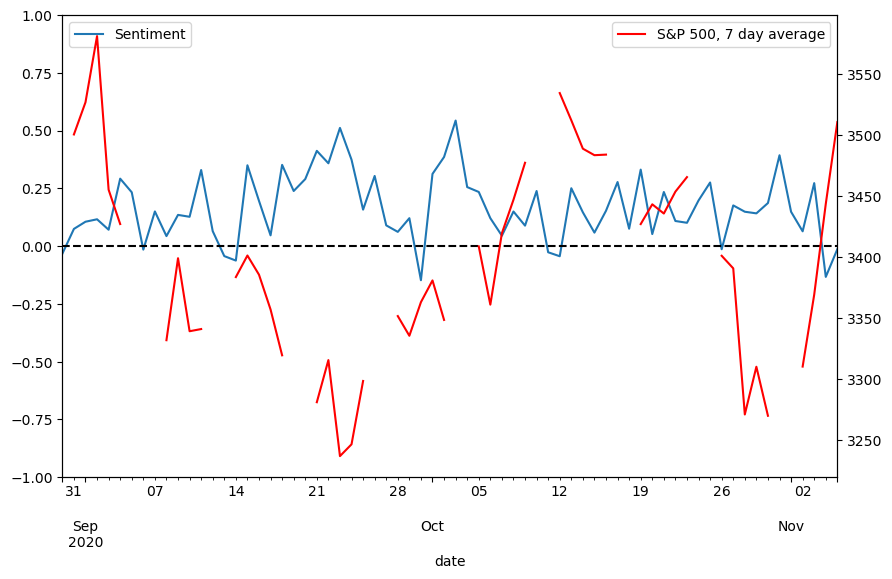

In [67]:
f,a = plt.subplots(figsize=(10,6))

price_and_sent['sentiment'].plot(ax=a,label="Sentiment")
plt.axhline(0,color="black",ls="--")
plt.legend(loc='upper left')
a.set_ylim(-1,1)
a2 = a.twinx()

# price_and_sent['SP500'].rolling(7,min_periods=1).mean().plot(ax=a2,color='red',label="S&P 500, 7 day average")
price_and_sent['SP500'].plot(ax=a2,color='red',label="S&P 500, 7 day average")

plt.legend()

### Group Discussion:
how you would answer the question: "Did President Trump's tweet sentiment influence the stock market?" Specifically describe:
- The data you would need in addition to these data sources.
- The way you would read in the data and manipulate it.
- The sort of analysis or statistics you would calculate to answer the question.

In [68]:
price_and_sent.corr()

,sentiment,SP500
sentiment,1.000000,-0.415257
SP500,-0.415257,1.000000


There is a somehwhat strong correlation between Trump's sentiment and S&P 500, but it is __negative__: the more positive Trump's Tweets are the lower stock prices are. A couple of possibilities:
- Spurious correlation ([for example](https://www.tylervigen.com/spurious-correlations)).
- Omitted variable bias: there is something that drives Trump's sentiment but also drives stock prices, which makes the relationship look stronger than it actually is. Certain events may be to blame more than Trump or the stock market; for example, certain events could be affecting both in opposite ways. This means it is __not a causal relationship__.
- Trump interprets things positively that the market inteprets as bullish. For example, many positive Trump tweets were congratulating the victories of certain politicians or policies that market may not welcome. This would __not be a causal relationship__. 
- Trump's comments during this period promoted distrust in institutions (such as mail-in voting) and were thought of as destabilizing, which the market may have interpreted as a bad signal for the economy. This would also be a __causal relationship__.

Note that the sizable jump in the stock market following November 3 indicate that Trump leaving office did appear to affect markets, since that was the most major event happening at the time.